In [20]:
import numpy as np
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt

## Вариант 2 - ASM,  MPR,  ENT, TR

In [45]:
class TextureAnalysis:
    def __init__(self, input_array, output_path):
        self.data = {}
        self.output_path = output_path
        self.load_img(input_array, True)
        self.d=1 

    def load_img(self, path, is_folder):
        if is_folder:
            for filename in os.listdir(path):
                if filename.endswith(('.png', '.bmp')):
                    image_path = os.path.join(path, filename)
                    self.data[filename[:-4]] = Image.open(image_path)
        else:
            self.data[os.path.basename(path)] = Image.open(path)

    def show_img(self):
        for img in self.data:
            img.show()

    def grayScale(self, np_img):
        return np.uint8(0.3 * np_img[:, :, 0] + 0.59 * np_img[:, :, 1] + 0.11 * np_img[:, :, 2])
    
    def calc_m(self, image):
        m = np.zeros((256,256))
        for x in range(self.d, image.shape[0] - self.d):
            for y in range(self.d, image.shape[1] - self.d):
                m[image[x - self.d, y], image[x, y]] += 1
                m[image[x + self.d, y], image[x, y]] += 1
                m[image[x, y - self.d], image[x, y]] += 1
                m[image[x, y + self.d], image[x, y]] += 1 

        return m

    def calc_norm_m(self, image):
        matrix = self.calc_m(image)
        for x in range(256):
            m = np.array(matrix[x])
            m[np.where(m == 0)] = 1
            matrix[x] = np.log(m)
        matrix = matrix * 256 / np.max(matrix)
        return matrix
    
    def calc_features(self, matrix):
        asm = np.square(matrix).sum()
        mpr = np.max(matrix)
        ent = - np.sum(matrix * np.log2(matrix + (matrix == 0)))
        tr = matrix.trace()
        return [asm, mpr, ent, tr]
    
    def add_contrast(self,image, c):
        table = np.array([((i / 255.0) ** c) * 255 for i in np.arange(0, 256)]).astype("uint8")
        # print(table)
        return cv2.LUT(image, table)
    
    def texture_analysis(self, name, image, c):
        print("Processing image "+name)
        np_img = np.array(image)
        m1 = self.calc_norm_m(np_img)
        
        plt.figure(figsize=(10, 10))
        plt.imshow(m1, cmap='gray')
        filename = os.path.join(self.output_path, name+"_cooccurrence_matrix"+".png")
        plt.savefig(filename)
        plt.clf()
       
        c_image = self.add_contrast(np.array(image.convert('L')), c)
        output_image = Image.fromarray(c_image.astype(np.uint8), "L")
        output_image.save(self.output_path+"/"+name+"_contrasted.png")

        m2 = self.calc_norm_m(c_image)
        
        plt.figure(figsize=(10, 10))
        plt.imshow(m2, cmap='gray')
        filename = os.path.join(self.output_path, name+"_contrasted_cooccurrence_matrix"+".png")
        plt.savefig(filename)
        plt.clf()

        _, ax = plt.subplots(2, 1)
        ax[0].hist(x=np_img.flatten(), bins=np.arange(0, 255))
        ax[1].hist(x=c_image.flatten(), bins=np.arange(0, 255))
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_path, name+"_hist"+".png"))

        f1 = self.calc_features(m1)
        f2 = self.calc_features(m2)
        print("Original image")
        print(f"ASM: {f1[0]}, MPR: {f1[1]}, ENT: {f1[2]}, TR: {f1[3]}")
        print("Contrasted image")
        print(f"ASM: {f2[0]}, MPR: {f2[1]}, ENT: {f2[2]}, TR: {f2[3]}")

    def texture_analysis_array(self, coeffs):
        for name, img, c in zip(self.data.keys(), self.data.values(), coeffs):
            np_img = np.array(img)
            gray_img = self.grayScale(np_img)
            output_image = Image.fromarray(gray_img)
            output_image.save(self.output_path+"/"+name+"_gray"+".png")
            # c = 0.5
            self.texture_analysis(name, output_image, c)

Processing image metallica
Original image
ASM: 97841096.99555229, MPR: 256.0, ENT: -7082748.234732514, TR: 29955.476164202355
Contrasted image
ASM: 87628931.85180277, MPR: 256.0, ENT: -6173443.990208484, TR: 27858.015452796404
Processing image bricks
Original image
ASM: 153788889.1608485, MPR: 256.0, ENT: -8453598.535755746, TR: 52230.446332299
Contrasted image
ASM: 93001175.53055125, MPR: 256.0, ENT: -5310838.9976992775, TR: 38186.042238528775
Processing image blank
Original image
ASM: 16140413.506745601, MPR: 256.0, ENT: -788580.1110956284, TR: 6477.847694597165
Contrasted image
ASM: 16140413.5067456, MPR: 256.0, ENT: -788580.1110956282, TR: 6477.847694597165
Processing image sand
Original image
ASM: 1024789109.7110069, MPR: 256.0, ENT: -55017945.151044786, TR: 42296.34942224715
Contrasted image
ASM: 659505386.34564, MPR: 256.0, ENT: -39890581.47295682, TR: 33675.06155068053


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

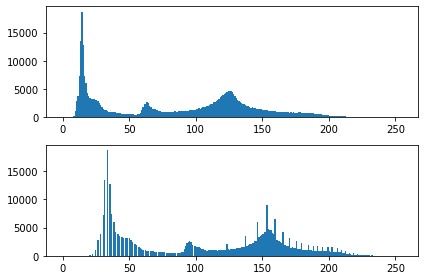

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

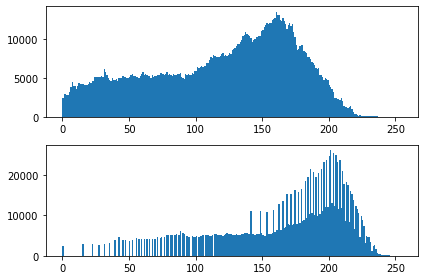

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

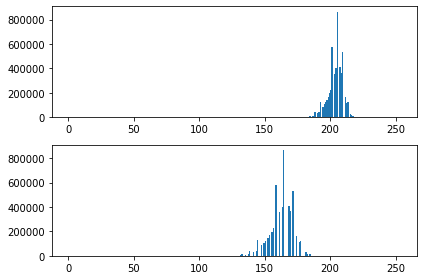

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

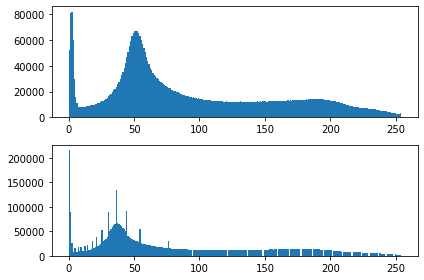

In [46]:
input_path = "./input"
output_path = "./output"

agent = TextureAnalysis(input_path, output_path)
coeffs = [0.7, 0.5, 2, 1.2]
# coeffs = [1.2]
agent.texture_analysis_array(coeffs)